# Scenario discovery : only to run the reference policy


The scenario discovery was implemented using 10000 scenarios on the reference policy. The outcomes of the scenario discovery are being used to run against the selected policies to assess their robustness. 

In [4]:
import ema_workbench
from ema_workbench import Model, MultiprocessingEvaluator, Policy, Scenario

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation

from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from ema_workbench import Samplers
from ema_workbench import MultiprocessingEvaluator


if __name__ == "__main__":
    ema_logging.log_to_stderr(ema_logging.INFO)

    dike_model, planning_steps = get_model_for_problem_formulation(6)

    reference_values = {
        "Bmax": 175,
        "Brate": 1.5,
        "pfail": 0.5,
        "ID flood wave shape": 4,
        "planning steps": 2,
    }
    reference_values.update({f"discount rate {n}": 3.5 for n in planning_steps})
    scen1 = {}

    for key in dike_model.uncertainties:
        name_split = key.name.split("_")

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario("reference", **scen1)

    zero_policy = {"DaysToThreat": 0}
    zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
    zero_policy.update({f"RfR {n}": 0 for n in planning_steps})
    pol0 = {}

    for key in dike_model.levers:
        s1, s2 = key.name.split("_")
        pol0.update({key.name: zero_policy[s2]})

    policy0 = Policy("Policy 0", **pol0)


    problem = get_SALib_problem(dike_model.uncertainties)
    print(problem) 

    n_scenarios = 10000

    with MultiprocessingEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(scenarios=n_scenarios, policies=policy0)


{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
100%|████████████████████████████████████| 10000/10000 [07:55<00:00, 21.03it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [5]:
ema_workbench.util.utilities.save_results(results, './results/behaviour_run_10000sc_refpol.tar.gz')

[MainProcess/INFO] results saved successfully to c:\Users\athaa\Desktop\epa141A_open\final assignment\results\behaviour_run_10000sc_refpol.tar.gz


In [7]:
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
from ema_workbench.util import utilities
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import prim
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

In [9]:
dike_model, steps = get_model_for_problem_formulation(6)

In [11]:
results = utilities.load_results('./results/behaviour_run_10000sc_refpol.tar.gz')
experiments, outcomes = results

[MainProcess/INFO] results loaded successfully from c:\Users\athaa\Desktop\epa141A_open\final assignment\results\behaviour_run_10000sc_refpol.tar.gz


In [12]:
experiments, outcomes = results
cleaned_experiments = experiments.drop(labels=[l.name for l in dike_model.levers], axis=1)

In [15]:
## In order to add the aggregated outcomes in the outcomes library, first we need to make a dataframe out of it:
outcomes_df = pd.DataFrame.from_dict(outcomes)

#In order for the prim algorithms to work we need to make a dictionary out of the aggregate_outcomes_df
all_outcomes_dic = {col: outcomes_df[col].to_numpy() for col in outcomes_df.columns}

## PRIM (disregard)

### Expected Number of Deaths

In [19]:
data = all_outcomes_dic['Expected Number of Deaths']

In [22]:
# Create a boolean array for values greater than the 80th percentile
y = data > np.percentile(data, 80)

[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 2000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.109, coverage: 0.545, density: 1.0 restricted_dimensions: 3


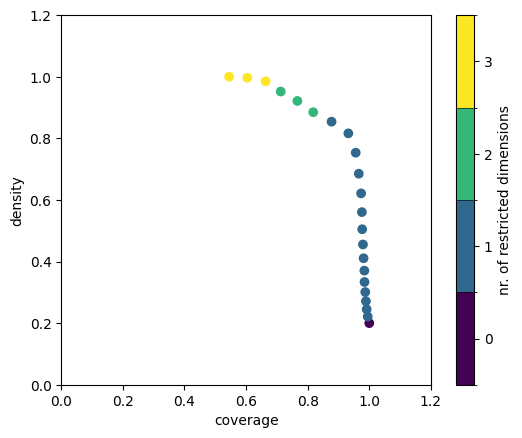

In [24]:
ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.75, peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff()
plt.show()

In [25]:
# Extract the box's criteria directly from box_lims attribute
box_criteria = box_1.box_lims

# Apply the box criteria to filter the DataFrame
condition = np.ones(len(cleaned_experiments), dtype=bool)

for box_idx, bounds in enumerate(box_criteria):
    print(f"Box {box_idx + 1} criteria:")
    try:
        if isinstance(bounds, tuple) and len(bounds) == 2:
            lower_bounds = bounds[0]
            upper_bounds = bounds[1]
            for index, (lower_bound, upper_bound) in enumerate(zip(lower_bounds, upper_bounds)):
                column_name = cleaned_experiments.columns[index]
                condition &= (cleaned_experiments[column_name] >= lower_bound) & (cleaned_experiments[column_name] <= upper_bound)
                print(f"Column: {column_name}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        else:
            print(f"Bounds structure not as expected for Box {box_idx + 1}: {bounds}")
    except KeyError as e:
        print(f"Error accessing bounds for Box {box_idx + 1}: {str(e)}")

# Select the experiments that meet the box criteria
experiments_in_box = cleaned_experiments[condition]

# Save to a CSV file
experiments_in_box.to_csv('results/experiments_in_box_deaths.csv', index=False)

Box 1 criteria:
Bounds structure not as expected for Box 1:    A.0_ID flood wave shape    A.1_Bmax         A.1_Brate  A.1_pfail  \
0                        0   30.013965  {1.5, 10.0, 1.0}   0.000094   
1                      132  349.991023  {1.5, 10.0, 1.0}   0.999923   

     A.2_Bmax         A.2_Brate  A.2_pfail    A.3_Bmax         A.3_Brate  \
0   30.021586  {1.5, 10.0, 1.0}   0.000002   30.000607  {1.5, 10.0, 1.0}   
1  349.973797  {1.5, 10.0, 1.0}   0.999940  349.973957  {1.5, 10.0, 1.0}   

   A.3_pfail    A.4_Bmax         A.4_Brate  A.4_pfail    A.5_Bmax  \
0   0.000093   30.014975  {1.0, 10.0, 1.5}   0.000067   30.001589   
1   0.999913  349.971763  {1.0, 10.0, 1.5}   0.999912  349.978822   

          A.5_Brate  A.5_pfail       discount rate 0       discount rate 1  \
0  {1.0, 10.0, 1.5}   0.000054  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   
1  {1.0, 10.0, 1.5}   0.999950  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   

        discount rate 2  
0  {1.5, 2.5, 3.5, 4.5}  
1 

In [29]:
# see where coverage is higher than 0.8 and density is higher than 0.6
potentials = box1.peeling_trajectory
potentials = potentials[(potentials.coverage > 0.8)
                         & (potentials.density > 0.8)]
potentials

,coverage,density,id,k,mass,mean,n,res_dim
14,0.9320,0.816112,14,1864,0.2284,0.816112,2284,1
15,0.8775,0.854015,15,1755,0.2055,0.854015,2055,1
16,0.8180,0.884803,16,1636,0.1849,0.884803,1849,2


In [33]:
chosen_box = potentials[potentials.density == potentials.density.min()]
chosen_box_id = int(chosen_box.iloc[0].name)
chosen_box_id

14

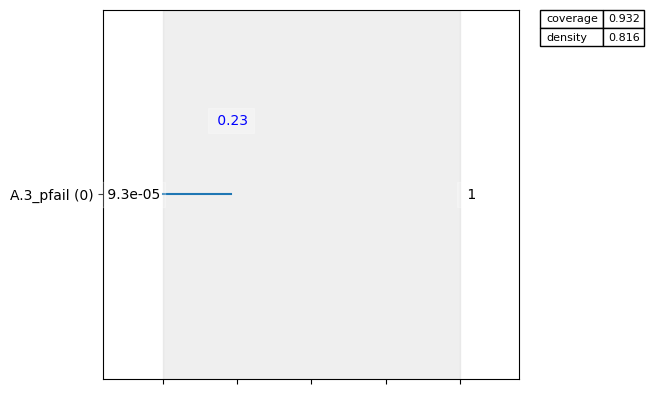

In [34]:
box1.select(chosen_box_id)
box1.inspect(style='graph')
plt.show()

## Dimensional Stacking

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


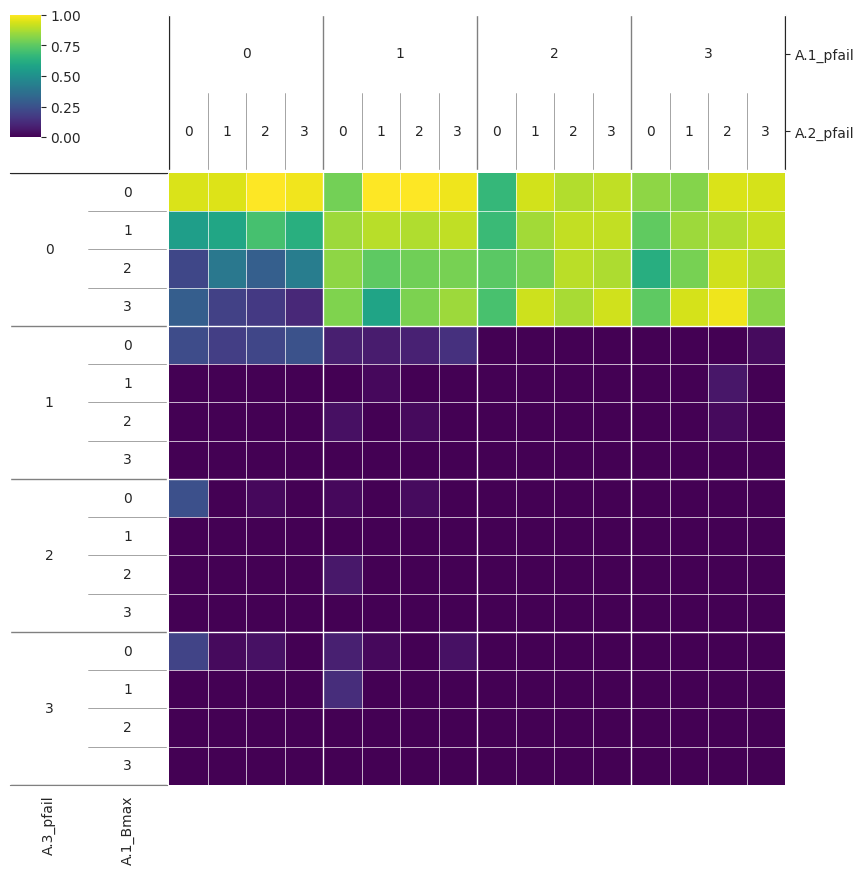

In [35]:
# Do dimensional stacking of results deaths
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(cleaned_experiments, y, 2, nbins=4)
plt.show()

## Expected annual damage

[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 2000 cases of interest
[MainProcess/INFO] mean: 0.924924924924925, mass: 0.0666, coverage: 0.308, density: 0.924924924924925 restricted_dimensions: 4


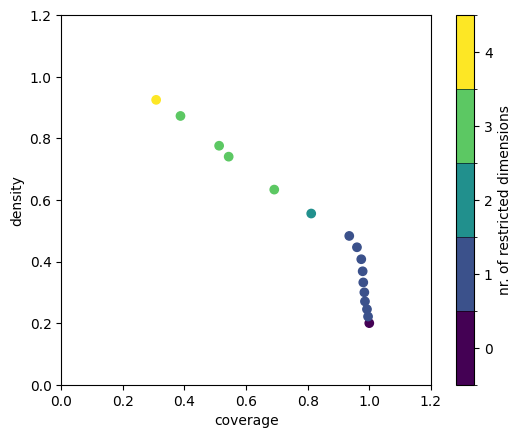

In [57]:
data = all_outcomes_dic['Expected Annual Damage']
# Create a boolean array for values greater than the 80th percentile
y = data > np.percentile(data, 80)
ema_logging.log_to_stderr(ema_logging.INFO)

prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.75, peel_alpha=0.1)
box2 = prim_alg.find_box()
box2.show_tradeoff()
plt.show()

In [59]:
# Extract the box's criteria directly from box_lims attribute
box_criteria = box2.box_lims

# Apply the box criteria to filter the DataFrame
condition = np.ones(len(cleaned_experiments), dtype=bool)

for box_idx, bounds in enumerate(box_criteria):
    print(f"Box {box_idx + 1} criteria:")
    try:
        if isinstance(bounds, tuple) and len(bounds) == 2:
            lower_bounds = bounds[0]
            upper_bounds = bounds[1]
            for index, (lower_bound, upper_bound) in enumerate(zip(lower_bounds, upper_bounds)):
                column_name = cleaned_experiments.columns[index]
                condition &= (cleaned_experiments[column_name] >= lower_bound) & (cleaned_experiments[column_name] <= upper_bound)
                print(f"Column: {column_name}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        else:
            print(f"Bounds structure not as expected for Box {box_idx + 1}: {bounds}")
    except KeyError as e:
        print(f"Error accessing bounds for Box {box_idx + 1}: {str(e)}")

# Select the experiments that meet the box criteria
experiments_in_box = cleaned_experiments[condition]

# Save to a CSV file
experiments_in_box.to_csv('results/experiments_in_box_damages.csv', index=False)


Box 1 criteria:
Bounds structure not as expected for Box 1:    A.0_ID flood wave shape    A.1_Bmax         A.1_Brate  A.1_pfail  \
0                        0   30.013965  {1.5, 10.0, 1.0}   0.000094   
1                      132  349.991023  {1.5, 10.0, 1.0}   0.999923   

     A.2_Bmax         A.2_Brate  A.2_pfail    A.3_Bmax         A.3_Brate  \
0   30.021586  {1.5, 10.0, 1.0}   0.000002   30.000607  {1.5, 10.0, 1.0}   
1  349.973797  {1.5, 10.0, 1.0}   0.999940  349.973957  {1.5, 10.0, 1.0}   

   A.3_pfail    A.4_Bmax         A.4_Brate  A.4_pfail    A.5_Bmax  \
0   0.000093   30.014975  {1.0, 10.0, 1.5}   0.000067   30.001589   
1   0.999913  349.971763  {1.0, 10.0, 1.5}   0.999912  349.978822   

          A.5_Brate  A.5_pfail       discount rate 0       discount rate 1  \
0  {1.0, 10.0, 1.5}   0.000054  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   
1  {1.0, 10.0, 1.5}   0.999950  {1.5, 2.5, 3.5, 4.5}  {1.5, 2.5, 3.5, 4.5}   

        discount rate 2  
0  {1.5, 2.5, 3.5, 4.5}  
1 

In [69]:
# see where coverage and density is high 
potentials = box2.peeling_trajectory
potentials

,coverage,density,id,k,mass,mean,n,res_dim
0,1.0000,0.200000,0,2000,1.0000,0.200000,10000,0
1,0.9960,0.221333,1,1992,0.9000,0.221333,9000,1
2,0.9925,0.245062,2,1985,0.8100,0.245062,8100,1
3,0.9860,0.270508,3,1972,0.7290,0.270508,7290,1
4,0.9840,0.299954,4,1968,0.6561,0.299954,6561,1
5,0.9805,0.332148,5,1961,0.5904,0.332148,5904,1
6,0.9785,0.368342,6,1957,0.5313,0.368342,5313,1
7,0.9740,0.407446,7,1948,0.4781,0.407446,4781,1
8,0.9600,0.446304,8,1920,0.4302,0.446304,4302,1
9,0.9350,0.483079,9,1870,0.3871,0.483079,3871,1


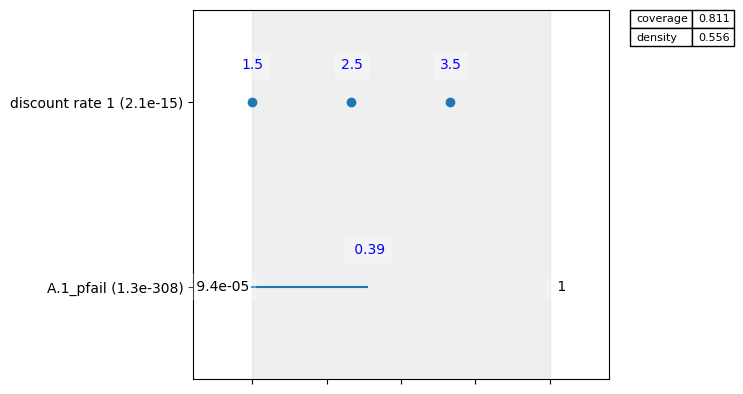

In [71]:
point = 10
box2.inspect(point,style='graph')
plt.show()

In [72]:
box2.resample(point)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


,reproduce coverage,reproduce density
A.1_pfail,100.0,100.0
discount rate 1,80.0,80.0
discount rate 2,20.0,20.0
A.0_ID flood wave shape,0.0,0.0
A.1_Bmax,0.0,0.0
A.1_Brate,0.0,0.0
A.2_Bmax,0.0,0.0
A.2_Brate,0.0,0.0
A.2_pfail,0.0,0.0
A.3_Bmax,0.0,0.0


The resampling shows that for the top 4 parameters we can exactly reproduce coverage and density. This confirms the suggestion of 4 dimensions. The other parameters can be safely ignored when interpreting the results.

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
c:\Users\athaa\miniconda3\envs\ema\Lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:408: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pvt = pd.pivot_table(x_y_concat, values=ooi_label, index=rows, columns=columns, dropna=False)


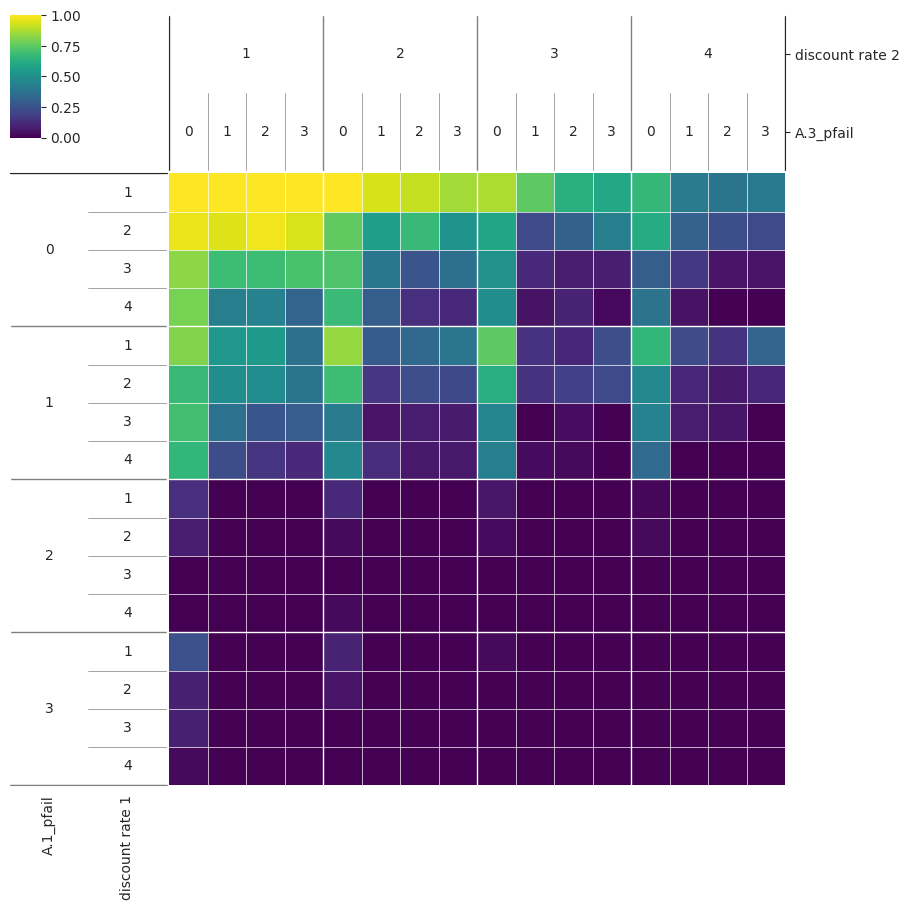

In [73]:
# Do dimensional stacking of results damage
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(cleaned_experiments, y, 2, nbins=4)
plt.show()

## Disaggregated Damage

For each dike ring?? cant bc i used PF 6 - all results aggregated already > have to make an explanation why we chose to do this